# 한영 번역기 만들기

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import time
import re
import os
import io

#나눔폰트 관련 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')

## 데이터 다운로드

한글을 영문으로 번역하기위한 데이터를 다운받겠다.
- 한영 병렬 데이터 출처 : [링크](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)
- Korean-English parallel corpus (v1b): 96,982 sentence-aligned corpus sentence (cleaned from v1) from the newswire articles collected from the Web (mostly from Yahoo! Korea and Joins CNN during 2010 and 2011).
- 데이터 상세 : https://sites.google.com/site/koreanparalleldata/




In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar.gz',
    origin='https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    extract=True)

print(path_to_zip)

8732672/8718893 [==============================] - 0s 0us/step
/root/.keras/datasets/korean-english-park.train.tar.gz


In [ ]:
#다운로드 파일및 압축해제파일 확인
!ls /root/.keras/datasets/

korean-english-park.train.en  korean-english-park.train.tar.gz
korean-english-park.train.ko


In [ ]:
path_to_file = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"
with open(path_to_file, "r") as f:
    raw_kor = f.read().splitlines()

print("Korean Data Size:", len(raw_kor))
print("Example:")

for sen in raw_kor[0:100][::20]: print(">>", sen)

Korean Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [ ]:
path_to_file = os.path.dirname(path_to_zip)+"/korean-english-park.train.en"
with open(path_to_file, "r") as f:
    raw_eng = f.read().splitlines()

print("English Data Size:", len(raw_eng))
print("Example:")

for sen in raw_eng[0:100][::20]: print(">>", sen)

English Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


LMS에서 한파일에 한영병렬데이터가 함께 들어 있던것과 다르게 각각 다른파일에 데이터가 들어가있으며, 번역 매칭은 줄단위로 구성되어있다.

각각의 파일에 94,123개의 문장이 존재한다.

In [ ]:
num_examples = len(raw_kor)
num_examples

94123

## 데이터 전처리

(1) 중복데이터 제거
 - 한글, 영문 문자 merge ->set로 중복제거

(2) 데이터 정제 - 정규식 적용

(3) 영문데이터에 <start>, <end> 토큰 추가

(4) 최대 문장 길이 설정, 최대 문장길이보다 큰 뉴스는 corpus에 포함시키지 않음


In [ ]:
# (1) 중복데이터 제거
raw_data = []
for kor, eng in zip(raw_kor, raw_eng):
    raw_data.append(kor + '\t' + eng) #tap키로 한영 데이터 구분

raw = set(raw_data)  #집합 set으로 변환 - 중복제거
raw_list = list(raw) #list로 변환

In [ ]:
dup_examples = num_examples - len(raw_list)
num_examples -= dup_examples
print(dup_examples, num_examples)

15155 78968


In [ ]:
num_examples = 30000

중복데이터로 15,155건이 삭제되었으며, 79000여건이 남았다. 

원활한 학습을 위해 상위 3만개의 데이터를 사용하겠다.

In [ ]:
# (2) 데이터 정제 - 정규식 적용
def preprocess_sentence_kor(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)       #단어와 붙어있는 기호를 띄워줌.
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)   # 한글과 [?.!,] 외 문자(특수문자 등) 공백으로 변환

    sentence = sentence.strip()

    return sentence

In [ ]:
def preprocess_sentence_eng(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1", sentence)       #단어와 붙어있는 기호를 띄워줌.
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence) # 영어와 [?.!,] 외 문자(특수문자 등) 공백으로 변환

    sentence = sentence.strip()
    
    #<start>, <end> 토큰 추가    
    sentence = '<start> ' + sentence
    sentence += ' <end>'
    
    return sentence


문장의 길이분포를 살펴보고 최대문장 길이를 설정하여 너무 긴문장은 제외하여 corpus를 구성하도록하겠다. 

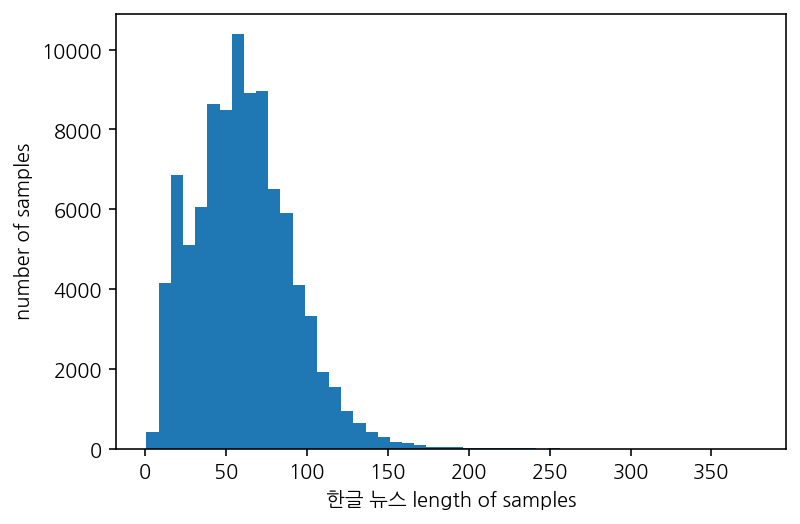

In [ ]:
plt.hist([len(sen) for sen in raw_kor], bins=50)
plt.xlabel('한글 뉴스 length of samples')
plt.ylabel('number of samples')
plt.show()

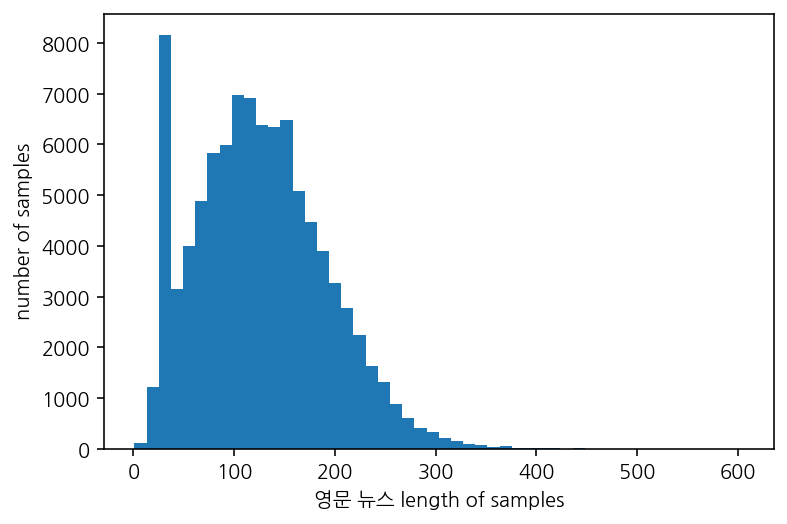

In [ ]:
plt.hist([len(sen) for sen in raw_eng], bins=50)
plt.xlabel('영문 뉴스 length of samples')
plt.ylabel('number of samples')
plt.show()

- 긴문장 처리
 - 분포상 한글뉴스의 경우 100 이상, 영문뉴스의 경우200 이상인 경우를 전처리를 진행하여 corpus를 구성하도록 하겠다.
 - 학습시 문장이 너무 길경우 loss값이 높아 한글의 경우 50, 영문의 경우 100이상의 문장은 제외하였다.

In [ ]:
enc_corpus = []
dec_corpus = []

for pair in raw_data[:num_examples]:
    kor, eng = pair.split("\t")
    
    #문장의 길이가 긴경우 제외 
    if len(kor) > 50 or len(eng)> 100:
        continue

    enc_corpus.append(preprocess_sentence_kor(kor))
    dec_corpus.append(preprocess_sentence_eng(eng))

print("Korean:", enc_corpus[100])   # go away !
print("English:", dec_corpus[100])   # <start> salga de aqu ! <end>
len(enc_corpus), len(dec_corpus)

Korean: 우주 비행사들의 증언이나 사진 상의 증거도 역시 충분하지 않았다 .
English: <start> neither was testimony from astronauts or even photographic evidence . <end>


(6765, 6765)

## 데이터 토큰화
전처리후 6,765 건의 데이터가 남았다. 이 데이터에 대하여 keras 토크나이저를 통해 토큰화를 진행하겠다. 

In [ ]:
def tokenize(corpus, max_len):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, tokenizer

In [ ]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus, 40)
dec_tensor, dec_tokenizer = tokenize(dec_corpus, 60)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 23869
English Vocab Size: 10786


In [ ]:
print('훈련 데이터 : ', enc_train.shape, dec_train.shape)
print('검증 데이터 : ', enc_val.shape, dec_val.shape)

훈련 데이터 :  (5412, 40) (5412, 60)
검증 데이터 :  (1353, 40) (1353, 60)


## 모델 설계
**BahdanauAttention**

- 디코더가 현재 시점 i에서 보기에 인코더의 어느 부분 j가 중요한지 가중치로 계산하여 반영

![ㅇ](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FwHsKw%2FbtrxUPTgWKb%2FxDLAJVDVc8JZ6EFPZzVy70%2Fimg.png)


**Encoder**
- Embedding Layer : 시퀀스 
- Gru Layer
 - enc_units : 히든 유닛수
 - return_sequences=True : 각 time step별 hidden state를 모두 출력
- cf. return_sequences=False : 1개의 벡터만 출력

**Decoder**
- t=1 일 때의 Hidden State : Encoder의 Final State를 Hidden State를 사용
- Gru Layer
 - return_state=True : 마지막 time step에서의 hidden state와 cell state가 출력
- Dense Layer :  히든 유닛수 vocab_size로 설정
- BahdanauAttention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
		
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)        
        self.attention = BahdanauAttention(dec_units)   # Attention 필수 사용!

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        #print('Decoder:', len(out), len(context_vec))
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [ ]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 #1 for pad
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 #1 for pad
print ('SRC_VOCAB_SIZE :', SRC_VOCAB_SIZE)
print ('TGT_VOCAB_SIZE :', TGT_VOCAB_SIZE)

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)
print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

SRC_VOCAB_SIZE : 23870
TGT_VOCAB_SIZE : 10787
Encoder Output: (64, 30, 1024)
Decoder Output: (64, 10787)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## 모델 훈련하기

(1) Optimizer & Loss
- optimizer : Adam 옵티마이터 사용
- loss
 - 손실 함수 : SparseCategoricalCrossentropy 사용
 - mask 설정 : 모델에게 \<PAD> 토큰이 패딩을 위한 토큰이라고 알려주기위한 처리

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

(2) train_step 
- 주요 파라미터
 - src : 한글 시퀀스
 - tgt : 영문 시퀀스
 - dec_tok : 영문 토크나이저
 
- GradientTape 구성
 - 인코더, 디코더를 통해 학습을 진행후 loss를 최종 계산후 반환

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0
    step = 1

    with tf.GradientTape() as tape:        
        enc_out = encoder(src)  #한글 시퀀스 인코딩
        h_dec = enc_out[:, -1]  # 컨텍스트 벡터 : 인코더 마지막 히든스테이트
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1) # 영문시퀀스 - 첫번째 : start 토큰        
        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out) # 영문시퀀스, 이전 히든스테이트(처음엔 :컨텍스트 벡터), enc_out

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1) # 다음 영문시퀀스
        
    batch_loss = (loss / int(tgt.shape[1]))
    #print(step, '--> batch_loss:', batch_loss)
    #step += 1

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

(3) 훈련 시작하기
- 훈련데이터에 대하여 미니배치로 train_step() 함수에서 학습
 - 인덱스 리스트중 랜덤으로 데이터 선택하여 훈련

In [ ]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss    #loss 합산
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 85/85 [00:54<00:00,  1.55it/s, Loss 1.5834]


## 실습하기

Validation Set을 사용하는 eval_step() 함수를 정의하도록 하겠다.  train_step() 을 마친 후, 곧이어 eval_step() 실행하여 훈련과 검증을 진행하였다. 


In [ ]:
# Define eval_step - 학습이 진행되지 않도록 가중치 갱신하는 부분 제외
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss



In [ ]:
# Training Process
from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 22/22 [00:05<00:00,  4.11it/s, Test Loss 1.4464]


## 성능 평가

In [ ]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    print(sentence, 'len:', enc_train.shape[-1])
    sentence = preprocess_sentence_kor(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=enc_train.shape[-1], padding='pre')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)
    print(enc_out)
    print(dec_hidden)
    print(dec_input)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()
        print(predicted_id, end='/ ')
        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            print('evaluate 1:', result)
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    print('evaluate 2:', result)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


---
프로젝트 과제에 제시되었던 예문으로 번역을 해보자.

시민들은 도시 속에 산다. len: 40
tf.Tensor(
[[[-1.3440872e-03  2.9736985e-03  1.3920106e-03 ... -3.0511240e-03
    4.4574909e-04 -9.0871016e-03]
  [-6.9560185e-03  2.6341486e-03 -2.2108534e-03 ...  3.1466137e-03
    1.0400856e-02  2.1928687e-02]
  [-2.7872523e-02 -3.1915063e-03 -1.2181106e-02 ...  1.2396603e-02
    2.1713898e-02  1.3890977e-02]
  ...
  [-9.9993593e-01  3.5368036e-02 -9.9980628e-01 ...  9.9988049e-01
    9.9993217e-01  9.2983681e-01]
  [-9.9993724e-01 -4.7439057e-03 -9.9979609e-01 ...  9.9987292e-01
    9.9992961e-01  9.3193728e-01]
  [-9.9993849e-01  1.4534271e-02 -9.9981159e-01 ...  9.9987936e-01
    9.9993098e-01  9.3404776e-01]]], shape=(1, 40, 1024), dtype=float32)
tf.Tensor(
[[-0.9999385   0.01453427 -0.9998116  ...  0.99987936  0.999931
   0.93404776]], shape=(1, 1024), dtype=float32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
4/ 132/ 123/ 3/ 2/ evaluate 1: the united states . <end> 
Input: 시민들은 도시 속에 산다 .
Predicted translation: the united states . <end> 


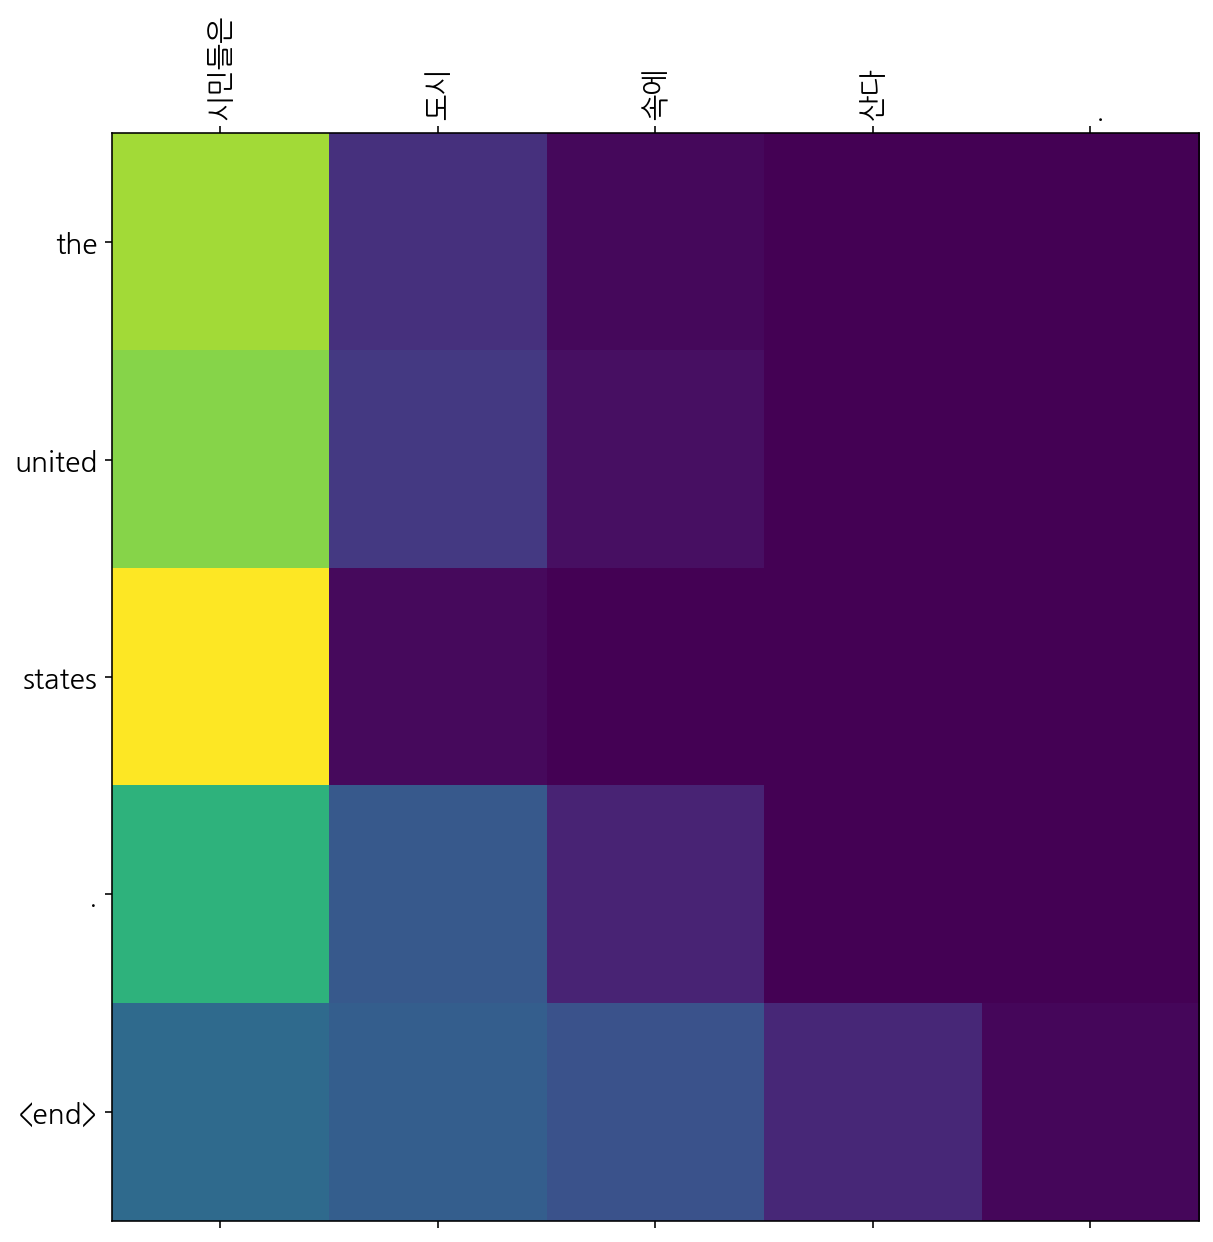

In [ ]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

---

## 정리.

- 결과적으로 원하는 성능의 모델이 만들어지지않았다. 로스값을 어느정도(3점대에서 1.6이하) 떨어뜨리기는 했지만 원하는 결과가 나오지않았다. LMS에서 진행했던 영어-스페인어 번역의 Loss(0.8이하)와 비교해도 학습이 잘진행되었다고 볼수없을 것 같다. 

- 개발 이슈
 - row data의 전체(94000여건)을 모두 학습시켰을때 OOM(Out of memory) 에러가발생하였다. 학습 건수를 30000건으로 줄였다.
 - 문장의 길이를 제한하지않은 경우 Loss가 nan(무한대)로 나왔다. 문장 길이가 너무 긴경우 학습이 제대로 진행되지않아 문장의 분포를 보고 조절하였지만 적절한 길이를 찾는 과정을 계속 반복했다. 
 - 드랍아웃이나 하이퍼 파라미터 조정으로도 크게 성능이 개선되지않았다. 인코더, 디코더 모델을 개선하는 방향이 좀더 유의미할것 같아 보인다.
 
